In [1]:
# need to set some versions
import sys 

# !{sys.executable} -m pip install pandas==1.1.5
# !{sys.executable} -m pip install tensorflow==1.13.1 # 1.15.0 # paper said us 1.10.0, but it doesn't exist???
# !{sys.executable} -m pip install numpy==1.19.5  # this one breaks on the tensor to numpy issue: 1.16.0 # tested with 1.16.0 # paper said us 1.15.3, but too many dependency conflicts
# !{sys.executable} -m pip install hmmlearn

# may have to restart kernel after running these to get access to them

In [2]:
#Importing/installing modules
from __future__ import absolute_import, division, print_function

import collections
import hashlib
import numbers
import itertools
import functools
import inspect
import pickle

from sklearn.model_selection import *
from sklearn.metrics import *



import tensorflow as tf
from tensorflow.contrib.rnn import PhasedLSTMCell, MultiRNNCell, BasicRNNCell
from tensorflow.python.ops import rnn_cell, rnn
from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op, dtypes, ops, tensor_shape, tensor_util   
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import * 
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.training import checkpointable
from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import tf_export

import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture

from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')

import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import shutil

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from hmmlearn import hmm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
pd.__version__

'1.1.5'

In [4]:
np.__version__

'1.19.5'

In [5]:
tf.__version__

'1.13.1'

In [6]:
# Python version - should be 3.6 or could have issues
print(sys.executable)
print(sys.version)
print(sys.version_info)

/opt/conda/bin/python
3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)


In [7]:
# pull up data for EDA
heal_df = pd.read_csv("CSV_DATA/DAP_2020_HLES_health_condition_v1.1.csv")

In [8]:
# MINOR EDA
print(len(heal_df))
print(list(heal_df.columns))
heal_df.head(10)

77576
['dog_id', 'hs_condition', 'hs_condition_cause_other_description', 'hs_condition_is_congenital', 'hs_condition_other_description', 'hs_condition_type', 'hs_diagnosis_month', 'hs_diagnosis_year', 'hs_eye_condition_cause', 'hs_follow_up_ongoing', 'hs_neurological_condition_vestibular_disease_type', 'hs_required_surgery_or_hospitalization']


,dog_id,hs_condition,hs_condition_cause_other_description,hs_condition_is_congenital,hs_condition_other_description,hs_condition_type,hs_diagnosis_month,hs_diagnosis_year,hs_eye_condition_cause,hs_follow_up_ongoing,hs_neurological_condition_vestibular_disease_type,hs_required_surgery_or_hospitalization
0,68063,423.0,NaN,False,NaN,4,3.0,2016.0,NaN,True,NaN,4.0
1,68063,426.0,NaN,False,NaN,4,3.0,2016.0,NaN,True,NaN,4.0
2,68063,712.0,NaN,False,NaN,7,3.0,2016.0,NaN,False,NaN,4.0
3,68063,714.0,NaN,False,NaN,7,8.0,2016.0,NaN,True,NaN,4.0
4,68063,1617.0,NaN,False,NaN,16,2.0,2017.0,NaN,True,NaN,4.0
5,68063,1817.0,NaN,False,NaN,18,8.0,2019.0,NaN,True,NaN,4.0
6,54147,1215.0,NaN,False,NaN,12,3.0,2020.0,NaN,True,NaN,4.0
7,54147,1803.0,NaN,False,NaN,18,6.0,2018.0,NaN,False,NaN,4.0
8,43693,305.0,NaN,False,NaN,3,3.0,2018.0,NaN,False,NaN,4.0
9,43693,307.0,NaN,False,NaN,3,1.0,2020.0,NaN,True,NaN,4.0


In [9]:
# need to know how many records per dog
# going to handle each entry as a separate visit for now, 
# but it looks like it is an entry per disease, so should massage later
# When come back to this: assume that if same month and same year, 
# but different diseases, it was during the same visit
heal_df.groupby('dog_id').count()

,hs_condition,hs_condition_cause_other_description,hs_condition_is_congenital,hs_condition_other_description,hs_condition_type,hs_diagnosis_month,hs_diagnosis_year,hs_eye_condition_cause,hs_follow_up_ongoing,hs_neurological_condition_vestibular_disease_type,hs_required_surgery_or_hospitalization
dog_id,,,,,,,,,,,
3,3,0,3,0,3,3,3,0,3,0,3
6,1,0,1,0,1,1,1,0,1,0,1
9,5,0,5,2,5,5,5,0,5,0,5
11,3,0,3,0,3,3,3,1,3,0,3
13,1,0,1,0,1,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
92568,7,0,7,4,7,7,7,0,7,0,7
92582,4,0,4,0,4,4,4,0,4,0,4
92584,3,0,3,0,3,3,3,0,3,0,3


In [10]:
seq_length = 4
# reduce to just dogs with 4+ health records
# then look at the most common conditions & most common surgical/hospitalization scenarios
sm_hl_df = heal_df[['dog_id', 'hs_condition_type','hs_required_surgery_or_hospitalization']]
# sm_hl_df.groupby('hs_condition_type').count()
# reduce to only dogs with seq_lenth+ of records
segmin_df = sm_hl_df[sm_hl_df.groupby('dog_id')['dog_id'].transform('size') > seq_length]
print(len(segmin_df))
# most common conditions
segmin_df.groupby('hs_condition_type').count()
# most common are (in order):
# 4, 3, 18, 16, 11, 1, etc.
# skin - 4 - 4990
# mouth/dental/oral - 3 - 4837
# trauma - 18 - 3231
# infection/parasites - 16 - 3197
# bone/orthoepedic - 11 - 2837
# eye - 1 - 2170

40712


,dog_id,hs_required_surgery_or_hospitalization
hs_condition_type,,
1,2765,2752
2,2215,2194
3,6434,6420
4,6384,6365
5,1353,1339
6,788,775
7,2497,2364
8,654,641
9,1442,1437


In [11]:
kicked = heal_df.loc[(heal_df['hs_condition']==1811),['dog_id', 'hs_condition_type','hs_required_surgery_or_hospitalization']]
kicked

,dog_id,hs_condition_type,hs_required_surgery_or_hospitalization
342,32832,18,4.0
1029,84553,18,4.0
1481,76775,18,4.0
2028,62034,18,4.0
2258,82174,18,4.0
...,...,...,...
74267,35175,18,4.0
75395,17203,18,4.0
76853,67329,18,4.0
77221,74735,18,2.0


In [12]:
# just looking at skin issues - want it broken down by hospitalized, surgery, both, none
skin1_df = heal_df[['dog_id', 'hs_condition_type','hs_required_surgery_or_hospitalization']]
# sm_hl_df.groupby('hs_condition_type').count()
# reduce to only dogs with seq_lenth+ of records
# segmin_df = skin1_df[skin1_df.groupby('dog_id')['dog_id'].transform('size') > seq_length]
print(len(skin1_df))
skin2_df = skin1_df.loc[(skin1_df['hs_condition_type']==3),['dog_id', 'hs_condition_type','hs_required_surgery_or_hospitalization']]
# most common conditions
skin2_df.groupby('hs_required_surgery_or_hospitalization').count()

77576


,dog_id,hs_condition_type
hs_required_surgery_or_hospitalization,,
1.0,6278,6278
2.0,143,143
3.0,430,430
4.0,4955,4955


In [13]:
# most common surgical/hospitalization scenarios
segmin_df.groupby('hs_required_surgery_or_hospitalization').count()

,dog_id,hs_condition_type
hs_required_surgery_or_hospitalization,,
1.0,5680,5680
2.0,1807,1807
3.0,1746,1746
4.0,31149,31149


# BASE DATA LOADING

In [14]:
def doggo_data_loading(seq_length=4, apply_seq_length=True, use_surg=True):
    # Data prep
    # pull up data
    heal_df = pd.read_csv("CSV_DATA/DAP_2020_HLES_health_condition_v1.1.csv")
    
    # reduce to just dogs with 4+ health records
    # then look at the most common conditions & most common surgical/hospitalization scenarios
    sm_hl_df = heal_df[['dog_id', 'hs_condition_type','hs_required_surgery_or_hospitalization']]

    # MOST COMMON ISSUES:
    filter_df = sm_hl_df.loc[(sm_hl_df['hs_condition_type']==4) | (sm_hl_df['hs_condition_type']==3) | (sm_hl_df['hs_condition_type']==18) | (sm_hl_df['hs_condition_type']==16) | (sm_hl_df['hs_condition_type']==11) | (sm_hl_df['hs_condition_type']==1),['dog_id', 'hs_condition_type','hs_required_surgery_or_hospitalization']]

    # reduce to only dogs with seq_lenth+ of records # turning off for now
    if apply_seq_length==True:
        segmin_df = filter_df[filter_df.groupby('dog_id')['dog_id'].transform('size') > seq_length]
    else: 
        segmin_df = filter_df

    # turn values into binary, adding new columns
    # if has 4, should be skin 1
    segmin_df['dis_skin'] = (segmin_df['hs_condition_type']==4).astype(int)
    segmin_df['dis_oral'] = (segmin_df['hs_condition_type']==3).astype(int)
    segmin_df['dis_trau'] = (segmin_df['hs_condition_type']==18).astype(int)
    segmin_df['dis_infe'] = (segmin_df['hs_condition_type']==16).astype(int)
    segmin_df['dis_bone'] = (segmin_df['hs_condition_type']==11).astype(int)
    segmin_df['dis_eyes'] = (segmin_df['hs_condition_type']==1).astype(int)
    
    final_df = segmin_df
    if use_surg==True:
        segmin_df['surgery'] = (segmin_df['hs_required_surgery_or_hospitalization']==1).astype(int)
        segmin_df['hospitalized'] = (segmin_df['hs_required_surgery_or_hospitalization']==2).astype(int)
        segmin_df['both_surg_hosp'] = (segmin_df['hs_required_surgery_or_hospitalization']==3).astype(int)
        # remove old columns
        final_df = segmin_df[['dog_id','dis_skin','dis_oral','dis_trau','dis_infe','dis_bone','dis_eyes','surgery','hospitalized','both_surg_hosp','hs_required_surgery_or_hospitalization']] 
    else:
        # remove old columns
        final_df = segmin_df[['dog_id','dis_skin','dis_oral','dis_trau','dis_infe','dis_bone','dis_eyes','hs_required_surgery_or_hospitalization']] 

    return final_df 


# Time-series Generative Adversarial Networks

In [15]:
#%% Min Max Normalizer

def MinMaxScaler3(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [16]:
def doggo_data_timeGANs(df):
    
    # remove old columns
    final_df = df[['dis_skin','dis_oral','dis_trau','surgery','hospitalized','both_surg_hosp']]

    # turn into segment vector
    x = final_df.to_numpy()
    
    # Flip the data to make chronological data
    x = x[::-1]
    
    # Min-Max Normalizer
    x = MinMaxScaler3(x)
    
    # Build dataset
    dataX = []
    
    for i in range(0, len(x) - seq_length):
        _x = x[i:i + seq_length]
        dataX.append(_x)
        
    # Mix Data (to make it similar to random sample)
    idx = np.random.permutation(len(dataX))
    
    outputX = []
    for i in range(len(dataX)):
        outputX.append(dataX[idx[i]])
    
    return outputX

In [17]:
#%% Main Parameters
# Experiments iterations
Iteration = 1 # 2
Sub_Iteration = 2 # 3

#%% Data Loading
seq_length = 4

df = doggo_data_loading(seq_length=4)
dataX = doggo_data_timeGANs(df)
    
print('doggo dataset is ready.')

doggo dataset is ready.


In [18]:
#%% Newtork Parameters
parameters = dict()

parameters['hidden_dim'] = len(dataX[0][0,:]) * 4
parameters['num_layers'] = 2 # 3
parameters['iterations'] = 1000 # 10000
parameters['batch_size'] = 64 # 128
parameters['module_name'] = 'gru'   # Other options: 'lstm' or 'lstmLN'
parameters['z_dim'] = len(dataX[0][0,:]) 

print('Parameters are ' + str(parameters))

#%% Experiments
# Output Initialization
Discriminative_Score = list()
Predictive_Score = list()

Parameters are {'hidden_dim': 24, 'num_layers': 2, 'iterations': 1000, 'batch_size': 64, 'module_name': 'gru', 'z_dim': 6}


In [19]:
# TimeGANs key functionality
#%% Min Max Normalizer

def MinMaxScaler2(dataX):
    
    min_val = np.min(np.min(dataX, axis = 0), axis = 0)
    dataX = dataX - min_val
    
    max_val = np.max(np.max(dataX, axis = 0), axis = 0)
    dataX = dataX / (max_val + 1e-7)
    
    return dataX, min_val, max_val

#%% Start TimeGAN function (Input: Original data, Output: Synthetic Data)

def timegan (dataX, parameters):
  
    # Initialization on the Graph
    tf.compat.v1.reset_default_graph()

    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0][0,:])
    
    # Maximum seq length and each seq length
    dataT = list()
    Max_Seq_Len = 0
    for i in range(No):
        Max_Seq_Len = max(Max_Seq_Len, len(dataX[i][:,0]))
        dataT.append(len(dataX[i][:,0]))
        
    # Normalization
    if ((np.max(dataX) > 1) | (np.min(dataX) < 0)):
        dataX, min_val, max_val = MinMaxScaler2(dataX)
        Normalization_Flag = 1
    else:
        Normalization_Flag = 0
     
    # Network Parameters
    hidden_dim   = parameters['hidden_dim'] 
    num_layers   = parameters['num_layers']
    iterations   = parameters['iterations']
    batch_size   = parameters['batch_size']
    module_name  = parameters['module_name']    # 'lstm' or 'lstmLN'
    z_dim        = parameters['z_dim']
    gamma        = 1
    
    #%% input place holders
    tf.compat.v1.disable_eager_execution()
    X = tf.compat.v1.placeholder(tf.float32, [None, Max_Seq_Len, data_dim], name = "myinput_x")
    Z = tf.compat.v1.placeholder(tf.float32, [None, Max_Seq_Len, z_dim], name = "myinput_z")
    T = tf.compat.v1.placeholder(tf.int32, [None], name = "myinput_t")
    
    #%% Basic RNN Cell
          
    def rnn_cell(module_name):
      # GRU
        if (module_name == 'gru'):
            rnn_cell = tf.compat.v1.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh)
      # LSTM
        elif (module_name == 'lstm'):
            rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(num_units=hidden_dim, activation=tf.nn.tanh)
      # LSTM Layer Normalization
        elif (module_name == 'lstmLN'):
            rnn_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(num_units=hidden_dim, activation=tf.nn.tanh)
        return rnn_cell
      
        
    #%% build a RNN embedding network      
    
    def embedder (X, T):      
      
        with tf.compat.v1.variable_scope("embedder", reuse = tf.compat.v1.AUTO_REUSE):
            
            e_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            e_outputs, e_last_states = tf.compat.v1.nn.dynamic_rnn(e_cell, X, dtype=tf.float32, sequence_length = T)
            
            H = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)

        return H
      
    ##### Recovery
    
    def recovery (H, T):      
      
        with tf.compat.v1.variable_scope("recovery", reuse = tf.compat.v1.AUTO_REUSE):       
              
            r_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            r_outputs, r_last_states = tf.compat.v1.nn.dynamic_rnn(r_cell, H, dtype=tf.float32, sequence_length = T)
            
            X_tilde = tf.contrib.layers.fully_connected(r_outputs, data_dim, activation_fn=tf.nn.sigmoid) 

        return X_tilde
    
    
    
    #%% build a RNN generator network
    
    def generator (Z, T):      
      
        with tf.compat.v1.variable_scope("generator", reuse = tf.compat.v1.AUTO_REUSE):
            
            e_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            e_outputs, e_last_states = tf.compat.v1.nn.dynamic_rnn(e_cell, Z, dtype=tf.float32, sequence_length = T)
            
            E = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     

        return E
      
    def supervisor (H, T):      
      
        with tf.compat.v1.variable_scope("supervisor", reuse = tf.compat.v1.AUTO_REUSE):
            
            e_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers-1)])
                
            e_outputs, e_last_states = tf.compat.v1.nn.dynamic_rnn(e_cell, H, dtype=tf.float32, sequence_length = T)
            
            S = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     

        return S
      
      
      
    #%% builde a RNN discriminator network 
    
    def discriminator (H, T):
      
        with tf.compat.v1.variable_scope("discriminator", reuse = tf.compat.v1.AUTO_REUSE):
            
            d_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            d_outputs, d_last_states = tf.compat.v1.nn.dynamic_rnn(d_cell, H, dtype=tf.float32, sequence_length = T)
            
            Y_hat = tf.contrib.layers.fully_connected(d_outputs, 1, activation_fn=None) 
    
        return Y_hat   
    
    
    #%% Random vector generation
    def random_generator (batch_size, z_dim, T_mb, Max_Seq_Len):
      
        Z_mb = list()
        
        for i in range(batch_size):
            
            Temp = np.zeros([Max_Seq_Len, z_dim])
            
            Temp_Z = np.random.uniform(0., 1, [T_mb[i], z_dim])
        
            Temp[:T_mb[i],:] = Temp_Z
            
            Z_mb.append(Temp_Z)
      
        return Z_mb
    
    #%% Functions
    
    # Embedder Networks
    H = embedder(X, T)
    X_tilde = recovery(H, T)
    
    # Generator
    E_hat = generator(Z, T)
    H_hat = supervisor(E_hat, T)
    H_hat_supervise = supervisor(H, T)
    
    # Synthetic data
    X_hat = recovery(H_hat, T)
    
    # Discriminator
    Y_fake = discriminator(H_hat, T)
    Y_real = discriminator(H, T)     
    Y_fake_e = discriminator(E_hat, T)
    
    # Variables        
    e_vars = [v for v in tf.compat.v1.trainable_variables() if v.name.startswith('embedder')]
    r_vars = [v for v in tf.compat.v1.trainable_variables() if v.name.startswith('recovery')]
    g_vars = [v for v in tf.compat.v1.trainable_variables() if v.name.startswith('generator')]
    s_vars = [v for v in tf.compat.v1.trainable_variables() if v.name.startswith('supervisor')]
    d_vars = [v for v in tf.compat.v1.trainable_variables() if v.name.startswith('discriminator')]
    
    # Loss for the discriminator
    D_loss_real = tf.compat.v1.losses.sigmoid_cross_entropy(tf.ones_like(Y_real), Y_real)
    D_loss_fake = tf.compat.v1.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake), Y_fake)
    D_loss_fake_e = tf.compat.v1.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake_e), Y_fake_e)
    D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e
            
    # Loss for the generator
    # 1. Adversarial loss
    G_loss_U = tf.compat.v1.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake), Y_fake)
    G_loss_U_e = tf.compat.v1.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake_e), Y_fake_e)
    
    # 2. Supervised loss
    G_loss_S = tf.compat.v1.losses.mean_squared_error(H[:,1:,:], H_hat_supervise[:,1:,:])
    
    # 3. Two Momments
    G_loss_V1 = tf.reduce_mean(input_tensor=np.abs(tf.sqrt(tf.nn.moments(x=X_hat,axes=[0])[1] + 1e-6) - tf.sqrt(tf.nn.moments(x=X,axes=[0])[1] + 1e-6)))
    # TODO - this is supposed to be an absolute value, see above, but won't take NP array - need to fix
    # try putting this back as it was, but changing TF version to 1.13.1
#     G_loss_V1 = tf.reduce_mean(input_tensor=tf.sqrt(tf.nn.moments(x=X_hat,axes=[0])[1] + 1e-6) - tf.sqrt(tf.nn.moments(x=X,axes=[0])[1] + 1e-6))
    G_loss_V2 = tf.reduce_mean(input_tensor=np.abs((tf.nn.moments(x=X_hat,axes=[0])[0]) - (tf.nn.moments(x=X,axes=[0])[0])))
 # TODO - this is supposed to be an absolute value, see above, but won't take NP array - need to fix
#     G_loss_V2 = tf.reduce_mean(input_tensor=(tf.nn.moments(x=X_hat,axes=[0])[0]) - (tf.nn.moments(x=X,axes=[0])[0]))
    
    G_loss_V = G_loss_V1 + G_loss_V2
    
    # Summation
    G_loss = G_loss_U + gamma * G_loss_U_e + 100 * tf.sqrt(G_loss_S) + 100*G_loss_V 
            
    # Loss for the embedder network
    E_loss_T0 = tf.compat.v1.losses.mean_squared_error(X, X_tilde)
    E_loss0 = 10*tf.sqrt(E_loss_T0)
    E_loss = E_loss0  + 0.1*G_loss_S
    
    # optimizer
    E0_solver = tf.compat.v1.train.AdamOptimizer().minimize(E_loss0, var_list = e_vars + r_vars)
    E_solver = tf.compat.v1.train.AdamOptimizer().minimize(E_loss, var_list = e_vars + r_vars)
    D_solver = tf.compat.v1.train.AdamOptimizer().minimize(D_loss, var_list = d_vars)
    G_solver = tf.compat.v1.train.AdamOptimizer().minimize(G_loss, var_list = g_vars + s_vars)      
    GS_solver = tf.compat.v1.train.AdamOptimizer().minimize(G_loss_S, var_list = g_vars + s_vars)   
        
    #%% Sessions    
    
    sess = tf.compat.v1.Session()
    sess.run(tf.compat.v1.global_variables_initializer())
    
    #%% Embedding Learning
    
    print('Start Embedding Network Training')
    
    for itt in range(iterations):
        
        # Batch setting
        idx = np.random.permutation(No)
        train_idx = idx[:batch_size]     
            
        X_mb = list(dataX[i] for i in train_idx)
        T_mb = list(dataT[i] for i in train_idx)
            
        # Train embedder        
        _, step_e_loss = sess.run([E0_solver, E_loss_T0], feed_dict={X: X_mb, T: T_mb})
        
        if itt % 1000 == 0:
            print('step: '+ str(itt) + ', e_loss: ' + str(np.round(np.sqrt(step_e_loss),4)) )        
            
    print('Finish Embedding Network Training')
    
    #%% Training Supervised Loss First
    
    print('Start Training with Supervised Loss Only')
    
    for itt in range(iterations):
        
        # Batch setting
        idx = np.random.permutation(No)
        train_idx = idx[:batch_size]     
            
        X_mb = list(dataX[i] for i in train_idx)
        T_mb = list(dataT[i] for i in train_idx)        
        
        Z_mb = random_generator(batch_size, z_dim, T_mb, Max_Seq_Len)
        
        # Train generator       
        _, step_g_loss_s = sess.run([GS_solver, G_loss_S], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})
                           
        if itt % 1000 == 0:
            print('step: '+ str(itt) + ', s_loss: ' + str(np.round(np.sqrt(step_g_loss_s),4)) )
                
    print('Finish Training with Supervised Loss Only')
    
    #%% Joint Training
    
    print('Start Joint Training')
    
    # Training step
    for itt in range(iterations):
      
        # Generator Training
        for kk in range(2):
          
            # Batch setting
            idx = np.random.permutation(No)
            train_idx = idx[:batch_size]     
            
            X_mb = list(dataX[i] for i in train_idx)
            T_mb = list(dataT[i] for i in train_idx)
            
            # Random vector generation
            Z_mb = random_generator(batch_size, z_dim, T_mb, Max_Seq_Len)
              
            # Train generator
            _, step_g_loss_u, step_g_loss_s, step_g_loss_v = sess.run([G_solver, G_loss_U, G_loss_S, G_loss_V], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})
            
            # Train embedder        
            _, step_e_loss_t0 = sess.run([E_solver, E_loss_T0], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})   
           
        #%% Discriminator Training
        
        # Batch setting
        idx = np.random.permutation(No)
        train_idx = idx[:batch_size]     
        
        X_mb = list(dataX[i] for i in train_idx)
        T_mb = list(dataT[i] for i in train_idx)
        
        # Random vector generation
        Z_mb = random_generator(batch_size, z_dim, T_mb, Max_Seq_Len)
            
        
        check_d_loss = sess.run(D_loss, feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
        
        # Train discriminator
        
        if (check_d_loss > 0.15):        
            _, step_d_loss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
        
        #%% Checkpoints
        if itt % 1000 == 0:
            print('step: '+ str(itt) + 
                  ', d_loss: ' + str(np.round(step_d_loss,4)) + 
                  ', g_loss_u: ' + str(np.round(step_g_loss_u,4)) + 
                  ', g_loss_s: ' + str(np.round(np.sqrt(step_g_loss_s),4)) + 
                  ', g_loss_v: ' + str(np.round(step_g_loss_v,4)) + 
                  ', e_loss_t0: ' + str(np.round(np.sqrt(step_e_loss_t0),4))  )
   
    
    print('Finish Joint Training')
    
    #%% Final Outputs
    
    Z_mb = random_generator(No, z_dim, dataT, Max_Seq_Len)
    
    X_hat_curr = sess.run(X_hat, feed_dict={Z: Z_mb, X: dataX, T: dataT})    
    
    #%% List of the final outputs
    
    dataX_hat = list()
    
    for i in range(No):
        Temp = X_hat_curr[i,:dataT[i],:]
        dataX_hat.append(Temp)
        
    # Renormalization
    if (Normalization_Flag == 1):
        dataX_hat = dataX_hat * max_val
        dataX_hat = dataX_hat + min_val
    
    return dataX_hat

In [20]:
#%% Post-hoc RNN Classifier 

def discriminative_score_metrics (dataX, dataX_hat):
  
    # Initialization on the Graph
    tf.reset_default_graph()

    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0][0,:])
    
    # Compute Maximum seq length and each seq length
    dataT = list()
    Max_Seq_Len = 0
    for i in range(No):
        Max_Seq_Len = max(Max_Seq_Len, len(dataX[i][:,0]))
        dataT.append(len(dataX[i][:,0]))
     
    # Network Parameters
    hidden_dim = max(int(data_dim/2),1)
    iterations = 2000
    batch_size = 128
    
    #%% input place holders
    # Features
    X = tf.placeholder(tf.float32, [None, Max_Seq_Len, data_dim], name = "myinput_x")
    X_hat = tf.placeholder(tf.float32, [None, Max_Seq_Len, data_dim], name = "myinput_x_hat")
    
    # Times
    T = tf.placeholder(tf.int32, [None], name = "myinput_t")
    T_hat = tf.placeholder(tf.int32, [None], name = "myinput_t_hat")
    
    #%% builde a RNN classification network 
    
    def discriminator (X, T):
      
        with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE) as vs:
            
            d_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh, name = 'cd_cell')
                    
            d_outputs, d_last_states = tf.nn.dynamic_rnn(d_cell, X, dtype=tf.float32, sequence_length = T)
                
            # Logits
            Y_hat = tf.contrib.layers.fully_connected(d_last_states, 1, activation_fn=None) 
            
            # Sigmoid output
            Y_hat_Final = tf.nn.sigmoid(Y_hat)
            
            # Variables
            d_vars = [v for v in tf.all_variables() if v.name.startswith(vs.name)]
    
        return Y_hat, Y_hat_Final, d_vars
    
    #%% Train / Test Division
    def train_test_divide (dataX, dataX_hat, dataT):
      
        # Divide train/test index
        No = len(dataX)
        idx = np.random.permutation(No)
        train_idx = idx[:int(No*0.8)]
        test_idx = idx[int(No*0.8):]
        
        # Train and Test X
        trainX = [dataX[i] for i in train_idx]
        trainX_hat = [dataX_hat[i] for i in train_idx]
        
        testX = [dataX[i] for i in test_idx]
        testX_hat = [dataX_hat[i] for i in test_idx]
        
        # Train and Test T
        trainT = [dataT[i] for i in train_idx]
        testT = [dataT[i] for i in test_idx]
      
        return trainX, trainX_hat, testX, testX_hat, trainT, testT
    
    #%% Functions
    # Variables
    Y_real, Y_pred_real, d_vars = discriminator(X, T)
    Y_fake, Y_pred_fake, _ = discriminator(X_hat, T_hat)
        
    # Loss for the discriminator
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Y_real, labels = tf.ones_like(Y_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Y_fake, labels = tf.zeros_like(Y_fake)))
    D_loss = D_loss_real + D_loss_fake
    
    # optimizer
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = d_vars)
        
    #%% Sessions    

    # Start session and initialize
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # Train / Test Division
    trainX, trainX_hat, testX, testX_hat, trainT, testT = train_test_divide (dataX, dataX_hat, dataT)
    
    # Training step
    for itt in range(iterations):
          
        # Batch setting
        idx = np.random.permutation(len(trainX))
        train_idx = idx[:batch_size]     
            
        X_mb = list(trainX[i] for i in train_idx)
        T_mb = list(trainT[i] for i in train_idx)
        
        # Batch setting
        idx = np.random.permutation(len(trainX_hat))
        train_idx = idx[:batch_size]     
            
        X_hat_mb = list(trainX_hat[i] for i in train_idx)
        T_hat_mb = list(trainT[i] for i in train_idx)
          
        # Train discriminator
        _, step_d_loss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, T: T_mb, X_hat: X_hat_mb, T_hat: T_hat_mb})            
        
        #%% Checkpoints
#        if itt % 500 == 0:
#            print("[step: {}] loss - d loss: {}".format(itt, np.round(step_d_loss,4)))
    
    #%% Final Outputs (ontTesting set)
    
    Y_pred_real_curr, Y_pred_fake_curr = sess.run([Y_pred_real, Y_pred_fake], feed_dict={X: testX, T: testT, X_hat: testX_hat, T_hat: testT})
    
    Y_pred_final = np.squeeze(np.concatenate((Y_pred_real_curr, Y_pred_fake_curr), axis = 0))
    Y_label_final = np.concatenate((np.ones([len(Y_pred_real_curr),]), np.zeros([len(Y_pred_real_curr),])), axis = 0)
    
    #%% Accuracy
    Acc = accuracy_score(Y_label_final, Y_pred_final>0.5)
    
    Disc_Score = np.abs(0.5-Acc)
    
    return Disc_Score

In [21]:
#%% PCA Analysis
    
def PCA_Analysis (dataX, dataX_hat):

    # Analysis Data Size
    Sample_No = 1000
    
    # Data Preprocessing
    for i in range(Sample_No):
        if (i == 0):
            arrayX = np.reshape(np.mean(np.asarray(dataX[0]),1), [1,len(dataX[0][:,0])])
            arrayX_hat = np.reshape(np.mean(np.asarray(dataX_hat[0]),1), [1,len(dataX[0][:,0])])
        else:
            arrayX = np.concatenate((arrayX, np.reshape(np.mean(np.asarray(dataX[i]),1), [1,len(dataX[0][:,0])])))
            arrayX_hat = np.concatenate((arrayX_hat, np.reshape(np.mean(np.asarray(dataX_hat[i]),1), [1,len(dataX[0][:,0])])))
    
    # Parameters        
    No = len(arrayX[:,0])
    colors = ["red" for i in range(No)] +  ["blue" for i in range(No)]    
    
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(arrayX)
    pca_results = pca.transform(arrayX)
    pca_hat_results = pca.transform(arrayX_hat)
        
    # Plotting
    f, ax = plt.subplots(1)
    
    plt.scatter(pca_results[:,0], pca_results[:,1], c = colors[:No], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], c = colors[No:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()
    
    
#%% TSNE Analysis
    
def tSNE_Analysis (dataX, dataX_hat):
  
    # Analysis Data Size
    Sample_No = 1000
  
    # Preprocess
    for i in range(Sample_No):
        if (i == 0):
            arrayX = np.reshape(np.mean(np.asarray(dataX[0]),1), [1,len(dataX[0][:,0])])
            arrayX_hat = np.reshape(np.mean(np.asarray(dataX_hat[0]),1), [1,len(dataX[0][:,0])])
        else:
            arrayX = np.concatenate((arrayX, np.reshape(np.mean(np.asarray(dataX[i]),1), [1,len(dataX[0][:,0])])))
            arrayX_hat = np.concatenate((arrayX_hat, np.reshape(np.mean(np.asarray(dataX_hat[i]),1), [1,len(dataX[0][:,0])])))
     
    # Do t-SNE Analysis together       
    final_arrayX = np.concatenate((arrayX, arrayX_hat), axis = 0)
    
    # Parameters
    No = len(arrayX[:,0])
    colors = ["red" for i in range(No)] +  ["blue" for i in range(No)]    
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(final_arrayX)
    
    # Plotting
    f, ax = plt.subplots(1)
    
    plt.scatter(tsne_results[:No,0], tsne_results[:No,1], c = colors[:No], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[No:,0], tsne_results[No:,1], c = colors[No:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

In [22]:
#%% Post-hoc RNN one-step ahead predictor

def predictive_score_metrics (dataX, dataX_hat):
  
    # Initialization on the Graph
    tf.reset_default_graph()

    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0][0,:])
    
    # Maximum seq length and each seq length
    dataT = list()
    Max_Seq_Len = 0
    for i in range(No):
        Max_Seq_Len = max(Max_Seq_Len, len(dataX[i][:,0]))
        dataT.append(len(dataX[i][:,0]))
     
    # Network Parameters
    hidden_dim = max(int(data_dim/2),1)
    iterations = 5000
    batch_size = 128
    
    #%% input place holders
    
    X = tf.placeholder(tf.float32, [None, Max_Seq_Len-1, data_dim-1], name = "myinput_x")
    T = tf.placeholder(tf.int32, [None], name = "myinput_t")    
    Y = tf.placeholder(tf.float32, [None, Max_Seq_Len-1, 1], name = "myinput_y")
    
    #%% builde a RNN discriminator network 
    
    def predictor (X, T):
      
        with tf.variable_scope("predictor", reuse = tf.AUTO_REUSE) as vs:
            
            d_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh, name = 'd_cell')
                    
            d_outputs, d_last_states = tf.nn.dynamic_rnn(d_cell, X, dtype=tf.float32, sequence_length = T)
                
            Y_hat = tf.contrib.layers.fully_connected(d_outputs, 1, activation_fn=None) 
            
            Y_hat_Final = tf.nn.sigmoid(Y_hat)
            
            d_vars = [v for v in tf.all_variables() if v.name.startswith(vs.name)]
    
        return Y_hat_Final, d_vars
    
    #%% Functions
    # Variables
    Y_pred, d_vars = predictor(X, T)
        
    # Loss for the predictor
    D_loss = tf.losses.absolute_difference(Y, Y_pred)
    
    # optimizer
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = d_vars)
        
    #%% Sessions    

    # Session start
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # Training using Synthetic dataset
    for itt in range(iterations):
          
        # Batch setting
        idx = np.random.permutation(len(dataX_hat))
        train_idx = idx[:batch_size]     
            
        X_mb = list(dataX_hat[i][:-1,:(data_dim-1)] for i in train_idx)
        T_mb = list(dataT[i]-1 for i in train_idx)
        Y_mb = list(np.reshape(dataX_hat[i][1:,(data_dim-1)],[len(dataX_hat[i][1:,(data_dim-1)]),1]) for i in train_idx)        
          
        # Train discriminator
        _, step_d_loss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, T: T_mb, Y: Y_mb})            
        
        #%% Checkpoints
#        if itt % 500 == 0:
#            print("[step: {}] loss - d loss: {}".format(itt, np.sqrt(np.round(step_d_loss,4))))
    
    #%% Use Original Dataset to test
    
    # Make Batch with Original Data
    idx = np.random.permutation(len(dataX_hat))
    train_idx = idx[:No]     
    
    X_mb = list(dataX[i][:-1,:(data_dim-1)] for i in train_idx)
    T_mb = list(dataT[i]-1 for i in train_idx)
    Y_mb = list(np.reshape(dataX[i][1:,(data_dim-1)], [len(dataX[i][1:,(data_dim-1)]),1]) for i in train_idx)
    
    # Predict Fugure
    pred_Y_curr = sess.run(Y_pred, feed_dict={X: X_mb, T: T_mb})
    
    # Compute MAE
    MAE_Temp = 0
    for i in range(No):
        MAE_Temp = MAE_Temp + mean_absolute_error(Y_mb[i], pred_Y_curr[i,:,:])
    
    MAE = MAE_Temp / No
    
    return MAE

In [23]:
# Run TimeGANs model
print('Start iterations') 
    
# Each Iteration
for it in range(Iteration):

    
    # Synthetic Data Generation
    dataX_hat = timegan(dataX, parameters)   
      
    print('Finish Synthetic Data Generation')

    #%% Performance Metrics
    
    # 1. Discriminative Score
    Acc = list()
    for tt in range(Sub_Iteration):
        Temp_Disc = discriminative_score_metrics (dataX, dataX_hat)
        Acc.append(Temp_Disc)
    
    Discriminative_Score.append(np.mean(Acc))
    
    # 2. Predictive Performance
    MAE_All = list()
    for tt in range(Sub_Iteration):
        MAE_All.append(predictive_score_metrics (dataX, dataX_hat))
        
    Predictive_Score.append(np.mean(MAE_All))    
    
print('Finish TimeGAN iterations')

Start iterations
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Start Embedding Network Training
step: 0, e_loss: 0.4937
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0, s_loss: 0.4277
Finish Training with Supervised Loss Only
Start Joint Training
step: 0, d_loss: 2.1463, g_loss_u: 0.6298, g_loss_s: 0.0286, g_loss_v: 0.4954, e_loss_t0: 0.1439
Finish Joint Training
Finish Synthetic Data Generation
Instructions for updating:
Please use tf.global_variables instead.
Finish TimeGAN it

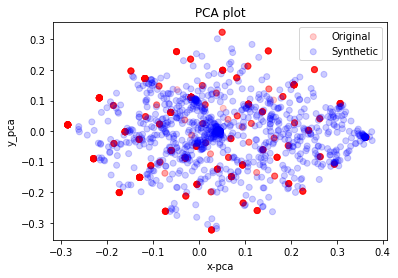

In [24]:
PCA_Analysis (dataX, dataX_hat)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.500862
[t-SNE] KL divergence after 300 iterations: 0.597633


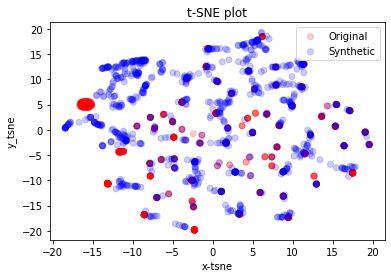

In [25]:
tSNE_Analysis (dataX, dataX_hat)

In [26]:
# Print Results
print('Discriminative Score - Mean: ' + str(np.round(np.mean(Discriminative_Score),4)) + ', Std: ' + str(np.round(np.std(Discriminative_Score),4)))
print('Predictive Score - Mean: ' + str(np.round(np.mean(Predictive_Score),4)) + ', Std: ' + str(np.round(np.std(Predictive_Score),4)))

Discriminative Score - Mean: 0.432, Std: 0.0
Predictive Score - Mean: 0.0527, Std: 0.0


In [27]:
dataX_hat

[array([[5.7389629e-01, 8.3723664e-04, 9.9584460e-04, 1.4991939e-02,
         1.2961030e-02, 5.2100122e-03],
        [9.7402894e-01, 6.1151385e-04, 1.0456145e-03, 2.1803290e-02,
         5.5980682e-03, 4.2179227e-03],
        [5.5561960e-03, 3.5887957e-04, 1.3661385e-04, 1.9378066e-02,
         5.9083700e-03, 6.9352984e-04],
        [1.7881393e-07, 5.0911307e-04, 9.8778540e-01, 6.6267729e-02,
         4.0930599e-02, 1.7773777e-02]], dtype=float32),
 array([[1.5722737e-01, 5.7137012e-04, 8.3416700e-04, 1.0764599e-02,
         1.4724761e-02, 4.3914616e-03],
        [9.8554164e-01, 6.6348910e-04, 1.2399554e-03, 2.7009070e-02,
         5.7190061e-03, 5.1325560e-03],
        [8.7685978e-01, 6.6590309e-04, 7.2294474e-04, 2.0316750e-02,
         4.7294796e-03, 2.5560558e-03],
        [2.9649457e-01, 6.0984492e-04, 4.0525198e-04, 2.0849258e-02,
         4.1413307e-03, 1.4835894e-03]], dtype=float32),
 array([[1.0371208e-05, 9.9119949e-01, 1.1017203e-02, 1.1775494e-03,
         4.2077714e-01, 5

# DISEASE TRAJECTORY STATE PREDICTIONS

In [28]:
def generate_doggo_trajectory(df):
   
    list_arr = []
    arry_list = np.array([])
    list_list = []
    list_feat = []
    cur_dog_id = final_df.iloc[0]['dog_id']
    
    final_df['state'] = 0.0
    state_list = []
    list_state_list = []
    
    for index, row in df.iterrows(): 
        # set up state lists
        if row['hs_required_surgery_or_hospitalization'] == 1.0:
            row['state'] = 3
        elif row['hs_required_surgery_or_hospitalization'] == 3.0:
            row['state'] = 4
        elif row['hs_required_surgery_or_hospitalization'] == 4.0:
            row['state'] = 1
        else:
            row['state'] = 2
        
        if cur_dog_id != row['dog_id']:
            arry_list = np.array(list_list)
            list_arr.append(arry_list)
            list_state_list.append(state_list)
        
            # reset various fields
            state_list = []
            arry_list = np.array([]) # shouldn't need this, but jic
            list_list = [] # reset the list of lists
            cur_dog_id = row['dog_id']

        list_feat = [row['dis_skin'],row['dis_oral'], row['dis_trau'], row['dis_infe'], row['dis_bone'], row['dis_eyes']]
        list_list.append(list_feat)
        state_list.append(row['state'])
        list_feat = [] # shouldn't need this, but jic
    
    # load final vars
    X_ = list_arr
    
    S_ = list_state_list
     
    return X_, S_ 

In [29]:
# generate the data
final_df = doggo_data_loading(apply_seq_length=False, use_surg=False)

X_observations, true_states = generate_doggo_trajectory(final_df)

In [30]:
trajectory_index = 3

true_states[trajectory_index]

[1.0, 3.0, 1.0, 2.0, 1.0]

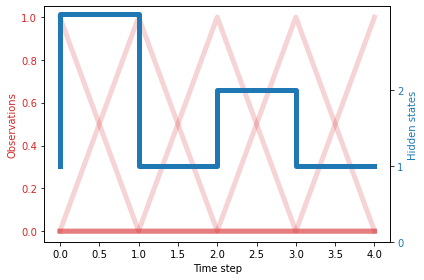

In [31]:
# Visualizing the hidden state data trajectories
fig, ax1 = plt.subplots()

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('Observations', color=color)
ax1.plot(t, X_observations[trajectory_index], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Hidden states', color=color)  
ax2.step(t, true_states[trajectory_index], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

In [32]:
# MODEL CLASSES:
class HMM:
    
    def __init__(self, num_states):
        
        self.num_states = num_states
        self.hmm_model  = hmm.GaussianHMM(n_components=num_states)
        
        
    def fit(self, X_obs):
        
        X_obser = [[list(X_obs[u][k,:]) for k in range(len(X_obs[u]))] for u in range(len(X_obs))]
        X_obs_  = np.concatenate(X_obser)

        lengths = [len(X_obs[k]) for k in range(len(X_obs))]
        
        self.hmm_model.fit(X_obs_, lengths)
        
        
    def predict(self, X_new):
        
        preds       = np.concatenate([self.hmm_model.predict(X_new[k]) for k in range(len(X_new))])
        predictions = [np.sum(np.concatenate([(self.hmm_model.transmat_[preds[k],u] * self.hmm_model.means_[u]).reshape((1,-1)) for u in range(self.num_states)]), axis=0).reshape((1,-1)) for k in range(len(preds))] 
        
        return np.concatenate(predictions)
        


@tf_export("nn.rnn_cell.MultiRNNCell")
class MultiPhasedLSTMCell(MultiRNNCell):

    def __init__(self, cells, state_is_tuple=True):
        
        super(MultiRNNCell, self).__init__()
        
        if not cells:
            raise ValueError("Must specify at least one cell for MultiRNNCell.")
        if not nest.is_sequence(cells):
            raise TypeError("cells must be a list or tuple, but saw: %s." % cells)

        self._cells = cells
        for cell_number, cell in enumerate(self._cells):
        
            # Add Checkpointable dependencies on these cells so their variables get
            # saved with this object when using object-based saving.
            if isinstance(cell, checkpointable.CheckpointableBase):
                # TODO(allenl): Track down non-Checkpointable callers.
                self._track_checkpointable(cell, name="cell-%d" % (cell_number,))
                self._state_is_tuple = state_is_tuple
            
            if not state_is_tuple:
                if any(nest.is_sequence(c.state_size) for c in self._cells):
                    raise ValueError("Some cells return tuples of states, but the flag "
                                     "state_is_tuple is not set.  State sizes are: %s"
                                     % str([c.state_size for c in self._cells]))

    @property
    def state_size(self):
        if self._state_is_tuple:
            return tuple(cell.state_size for cell in self._cells)
        else:
            return sum([cell.state_size for cell in self._cells])

    @property
    def output_size(self):
        return self._cells[-1].output_size

    def zero_state(self, batch_size, dtype):
        with ops.name_scope(type(self).__name__ + "ZeroState", values=[batch_size]):
            if self._state_is_tuple:
                return tuple(cell.zero_state(batch_size, dtype) for cell in self._cells)
            else:
                # We know here that state_size of each cell is not a tuple and
                # presumably does not contain TensorArrays or anything else fancy
                return super(MultiRNNCell, self).zero_state(batch_size, dtype)

    def call(self, inputs, state):
        """Run this multi-layer cell on inputs, starting from state."""
        cur_state_pos = 0

        times         = inputs[0]
        cur_inp       = inputs[1]
        
        new_states    = []
    
        for i, cell in enumerate(self._cells):
            with vs.variable_scope("cell_%d" % i):
                if self._state_is_tuple:
                    if not nest.is_sequence(state):
                        raise ValueError("Expected state to be a tuple of length %d, but received: %s" %(len(self.state_size), state))
                    cur_state = state[i]
                else:
                    cur_state = array_ops.slice(state, [0, cur_state_pos],
                                      [-1, cell.state_size])
                    cur_state_pos += cell.state_size
                
                cur_inp, new_state = cell((times, cur_inp), cur_state)
                new_states.append(new_state)

        new_states = (tuple(new_states) if self._state_is_tuple else array_ops.concat(new_states, 1))

        return cur_inp, new_states


def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper


def padd_data(X, padd_length):
    
    X_padded      = []
    
    for k in range(len(X)):
        
        if X[k].shape[0] < padd_length:
            
            if len(X[k].shape) > 1:
                X_padded.append(np.array(np.vstack((np.array(X[k]), 
                                                    np.zeros((padd_length-X[k].shape[0],X[k].shape[1]))))))
            else:
                X_padded.append(np.array(np.vstack((np.array(X[k]).reshape((-1,1)),
                                                    np.zeros((padd_length-X[k].shape[0],1))))))
                
        else:
            
            if len(X[k].shape) > 1:
                X_padded.append(np.array(X[k]))
            else:
                X_padded.append(np.array(X[k]).reshape((-1,1)))
  

    X_padded      = np.array(X_padded)

    return X_padded


def flatten_sequences_to_numpy(sequence_list):
    
    seqLists   = [list(itertools.chain.from_iterable(sequence_list[k].tolist())) for k in range(len(sequence_list))]
    flat_seqs  = np.array(list(itertools.chain.from_iterable(seqLists)))
    
    return flat_seqs


def state_to_array(state_index, number_of_states):
    
    state_array = np.zeros(number_of_states)
    state_array[state_index] = 1
    
    return state_array
    
    

def get_transitions(state_array, num_states):
    
    trans_matrix = np.zeros((num_states, num_states))
    each_state   = [np.sum((state_array==k)*1) for k in range(num_states)]
    
    for k in range(num_states):
        
        where_states       = np.where(state_array==k)[0]
        where_states_      = where_states[where_states < len(state_array) - 1]
        
        after_states       = [state_array[where_states_[k] + 1] for k in range(len(where_states_))]
        trans_matrix[k, :] = np.array([(np.where(np.array(after_states)==k))[0].shape[0] for k in range(num_states)])
        
    return trans_matrix, each_state


class attentive_state_space_model:
    
    '''
    Class for the "Attentive state space model" implementation. Based on the paper: 
    "Attentive state space model for disease progression" by Ahmed M. Alaa and Mihaela van der Schaar.
    
    ** Key arguments **
    
    :param maximum_seq_length: Maximum allowable length for any trajectory in the training data. 
    :param input_dim: Dimensionality of the observations (emissions).
    :param num_states: Cardinality of the state space.
    :param inference_network: Configuration of the inference network. Default is: 'Seq2SeqAttention'.
    :param rnn_type: Type of RNN cells to use in the inference network. Default is 'LSTM'.
    :param unsupervised: Boolean for whether the model is supervised or unsupervised. Default is True. 
                         Supervised is NOT IMPLEMENTED.
    :param generative: Boolean for whether to enable sampling from the model. 
    :param irregular: Whether the trajectories are in continuous time. NOT IMPLEMENTED.
    :param multitask: Boolean for whether multi-task output layers are used in inference network. NOT IMPLEMENTED
    :param num_iterations: Number of iterations for the stochastic variational inference algorithm.
    :param num_epochs: Number of epochs for the stochastic variational inference algorithm.
    :param batch_size: Size of the batch subsampled from the training data.
    :param learning_rate: Learning rate for the ADAM optimizer. (TO DO: enable selection of the optimizer)
    :param num_rnn_hidden: Size of the RNN layers used in the inference network.
    :param num_rnn_layers: Number of RNN layers used in the inference network.
    :param dropout_keep_prob: Dropout probability. Default is None.
    :param num_out_hidden: Size of output layer in inference network.
    :param num_out_layers: Size of output layer in inference network.
    ** Key attributes **
    
    After fitting the model, the key model parameters are stored in the following attributes:
    
    :attr states_mean: Mean of each observation in each of the num_states states.
    :attr states_covars: Covariance matrices of observations.
    :attr transition_matrix: Baseline Markov transition matrix for the attentive state space.
    :attr intial probabilities: Initial distribution of states averaged accross all trajectories in training data.
    
    ** Key methods **
    
    Three key methods are implemented in the API:
    
    :method fit: Takes a list of observations and fits an attentive state space model in an unsupervised fashion.
    :method predict: Takes a new observation and returns three variables:
                     - Prediction of the next state at every time step.
                     - Expected observation at the next time tep.
                     - List of attention weights assigned to previous states at every time step.
    :method sample: This method samples synthetic trajectories from the model.
    '''
    
    def __init__(self, 
                 maximum_seq_length, 
                 input_dim, 
                 num_states=3,
                 inference_network='Seq2SeqAttention', 
                 rnn_type='LSTM',
                 unsupervised=True,
                 generative=True,
                 irregular=False,
                 multitask=False,
                 input_name="Input", 
                 output_name="Output",
                 model_name="SeqModel",
                 num_iterations=50, 
                 num_epochs=10, 
                 batch_size=100, 
                 learning_rate=5*1e-4, 
                 num_rnn_hidden=100, 
                 num_rnn_layers=1,
                 dropout_keep_prob=None,
                 num_out_hidden=100, 
                 num_out_layers=1,
                 verbosity=True,
                 **kwargs
                ):
        
        # Set all model variables

        self.maximum_seq_length = maximum_seq_length 
        self.input_dim          = input_dim
        self.num_states         = num_states
        self.inference_network  = inference_network
        self.rnn_type           = rnn_type
        self.unsupervised       = unsupervised
        self.generative         = generative
        self.irregular          = irregular
        self.multitask          = multitask
        self.input_name         = input_name 
        self.output_name        = output_name 
        self.model_name         = model_name
        self.num_iterations     = num_iterations
        self.num_epochs         = num_epochs
        self.batch_size         = batch_size
        self.learning_rate      = learning_rate
        self.num_rnn_hidden     = num_rnn_hidden
        self.num_rnn_layers     = num_rnn_layers
        self.dropout_keep_prob  = dropout_keep_prob
        self.num_out_hidden     = num_out_hidden
        self.num_out_layers     = num_out_layers
        self.verbosity          = verbosity
        
        
        self.build_attentive_inference_network()
        
        tf.reset_default_graph()
        
        self.build_attentive_inference_graph()
        
        
    
    def build_attentive_inference_network(self):
        
        # replace this with dictionary style indexing
        
        model_options_names     = ['RNN','LSTM','GRU','PhasedLSTM']
        
        optimizer_options_names = []
        
        
        model_options   = [BasicRNNCell(self.num_rnn_hidden), 
                           rnn_cell.LSTMCell(self.num_rnn_hidden), 
                           rnn_cell.GRUCell(self.num_rnn_hidden), 
                           PhasedLSTMCell(self.num_rnn_hidden)]
        
        self._rnn_model = model_options[np.where(np.array(model_options_names)==self.rnn_type)[0][0]]
        
        if self.dropout_keep_prob is not None:
            
            self._rnn_model = tf.nn.rnn_cell.DropoutWrapper(self._rnn_model, output_keep_prob=self.dropout_keep_prob)
        
        self._Losses = []
        

    def build_attentive_inference_graph(self):
        
        self.observation = tf.placeholder(tf.float32, 
                                     [None, self.maximum_seq_length, self.input_dim], 
                                     name=self.input_name)
            
        self.state_guess = tf.placeholder(tf.float32, 
                                     [None, self.maximum_seq_length, self.num_states]) 
        
        if self.irregular:
            
            self.times      = tf.placeholder(tf.float32, [None, self.maximum_seq_length, 1])
            self.rnn_input  = (self.times, self.observation)
        
        else:
            
            self.rnn_input  = self.observation

            
    @lazy_property
    def length(self):
        
        used   = tf.sign(tf.reduce_max(tf.abs(self.observation), reduction_indices=2))
        length = tf.reduce_sum(used, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        
        return length

    @lazy_property
    def forward(self):
        
        self.attentive_inference_network_inputs()
        
        # Recurrent network.   
        if self.inference_network != 'Seq2SeqAttention': 
            
            rnn_output, _  = rnn.dynamic_rnn(self._rnn_model, 
                                             self.rnn_input_, 
                                             dtype=tf.float32, 
                                             sequence_length=self.length_,)
        else:
            
            try:
                
                tf.nn.seq2seq = tf.contrib.legacy_seq2seq
                tf.nn.rnn_cell = tf.contrib.rnn
                tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

                if self.verbosity:
                    
                    print("TensorFlow version : >= 1.0")
            
            except: 
            
                print("TensorFlow version : 0.12")
            
            if self.verbosity:
                
                print("---------------------------")
            
            self.enc_inp    = [self.rnn_input_[:, t, :] for t in range(self.maximum_seq_length)]

            self.dec_output = [tf.placeholder(tf.float32, shape=(None, 1), 
                                              name="dec_output_".format(t)) for t in range(self.maximum_seq_length)]

            self.dec_inp    = [tf.zeros_like(self.enc_inp[0], dtype=np.float32, name="GO")] + self.enc_inp[:-1] 

            self.cells = []
    
            for i in range(self.num_rnn_layers):
                
                with tf.variable_scope('RNN_{}'.format(i)):
                    
                    self.cells.append(tf.nn.rnn_cell.LSTMCell(self.num_rnn_hidden))
            
            
            self.cell  = tf.nn.rnn_cell.MultiRNNCell(self.cells)
            self.dec_outputs, self.dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(self.enc_inp, self.dec_inp, self.cell) 
            
            self.weight_dec, self.bias_dec = self._weight_and_bias(self.num_rnn_hidden, 1, ["w_dec", "b_dec"])
            
            self.seq2seq_attn = [(tf.matmul(i, self.weight_dec) + self.bias_dec) for i in self.dec_outputs]
            self.seq2seq_attn = tf.nn.softmax(tf.reshape(tf.stack(self.seq2seq_attn), 
                                                         [-1, self.maximum_seq_length, 1]), axis=1)
            
        
        # Softmax layer.
        self.combiner_func_weight, self.combiner_func_bias = self._weight_and_bias(self.input_dim, 
                                                                                   self.num_out_hidden, 
                                                                                   ["w_0", "b_0"])
        
        self.weight, self.bias     = self._weight_and_bias(self.num_out_hidden, 
                                                           self.num_states, 
                                                           ["w", "b"])
            
        # Flatten to apply same weights to all time steps.
        
        if self.inference_network not in ['RETAIN', 'Seq2SeqAttention']: 
            
            rnn_output  = tf.reshape(rnn_output, [-1, self.num_out_hidden])
            
            forward     = tf.nn.softmax(tf.matmul(rnn_output, self.weight) + self.bias)
        
        elif self.inference_network == 'RETAIN':
            
            self.weight_a, self.bias_a = self._weight_and_bias(self.num_out_hidden, 1, ["w_a", "b_a"])
            
            rnn_output      = tf.reshape(rnn_output, [-1, self.num_out_hidden])
            
            self.attention  = tf.nn.softmax(tf.reshape(tf.matmul(rnn_output, self.weight_a) + self.bias_a, 
                                                       [-1, self.maximum_seq_length, 1]), axis=1)
            

            attn_mask       = tf.expand_dims(tf.sign(tf.reduce_max(tf.abs(self.rnn_input_), reduction_indices=2)), axis=2)
            masked_attn     = tf.multiply(attn_mask, self.attention)
            attn_norms      = tf.expand_dims(tf.tile(tf.reduce_sum(masked_attn, axis=1), [1, self.maximum_seq_length]), axis=2)
            self.attention  = masked_attn/attn_norms
            self.attention_ = tf.tile(self.attention, [1, 1, self.input_dim])
            self.context    = tf.reduce_sum(tf.multiply(self.attention_, self.rnn_input_), reduction_indices=1)
            
            context_layer   = tf.matmul(self.context, self.combiner_func_weight ) + self.combiner_func_bias
            forward         = tf.nn.softmax(tf.matmul(context_layer, self.weight) + self.bias)
        
        elif self.inference_network == 'Seq2SeqAttention':
            
            self.attention  = self.seq2seq_attn
            
            attn_mask       = tf.expand_dims(tf.sign(tf.reduce_max(tf.abs(self.rnn_input_), reduction_indices=2)), axis=2)            
            masked_attn     = tf.multiply(attn_mask, self.attention)
            attn_norms      = tf.expand_dims(tf.tile(tf.reduce_sum(masked_attn, axis=1), [1, self.maximum_seq_length]), axis=2)
            self.attention  = masked_attn/attn_norms
            self.attention_ = tf.tile(self.attention, [1, 1, self.input_dim])
            self.context    = tf.reduce_sum(tf.multiply(self.attention_, self.rnn_input_), reduction_indices=1)
            context_layer   = tf.matmul(self.context, self.combiner_func_weight ) + self.combiner_func_bias
            forward         = tf.nn.softmax(tf.matmul(context_layer, self.weight) + self.bias)

        forward         = tf.reshape(forward, [-1, self.maximum_seq_length, self.num_states])
        
        self.predicted  = forward
        self.predicted  = tf.identity(self.predicted, name=self.output_name)
        
        return forward

    
    def attentive_inference_network_inputs(self):
        
        if self.inference_network in ['RETAIN', 'Seq2SeqAttention']: 
            
            self.num_samples = tf.shape(self.observation)[0] 
             
            Lengths_         = np.repeat(self.length, self.maximum_seq_length)
            
            conv_data        = tf.reshape(tf.tile(self.observation, [1, self.maximum_seq_length, 1]), 
                                          [self.maximum_seq_length * self.num_samples, 
                                           self.maximum_seq_length, self.input_dim])
            
            conv_mask_       = tf.ones([self.maximum_seq_length, self.maximum_seq_length], tf.float32)
            
            conv_mask        = tf.tile(tf.expand_dims(tf.tile(tf.matrix_band_part(conv_mask_, -1, 0), 
                                                              [self.num_samples, 1]), 2), 
                                                              [1, 1, self.input_dim])
            
            masked_data   = tf.multiply(conv_data, conv_mask)
            
            Seq_lengths_  = tf.tile(tf.range(1, self.maximum_seq_length + 1, 1), [self.num_samples])
            
            if self.inference_network == 'RETAIN':
            
                self.rnn_input_  = tf.reverse_sequence(masked_data, batch_axis=0, seq_dim=1, 
                                                       seq_lengths=Seq_lengths_, seq_axis=None)
            else:
                
                self.rnn_input_  = masked_data
                
            
            used         = tf.sign(tf.reduce_max(tf.abs(self.rnn_input_), reduction_indices=2))
            length       = tf.reduce_sum(used, reduction_indices=1)
            self.length_ = tf.cast(length, tf.int32)

            
        else:    
            
            self.rnn_input_ = self.rnn_input
            self.length_    = self.length

            
    @lazy_property
    def ELBO(self):

        mask                = tf.sign(tf.reduce_max(tf.abs(self.observation), reduction_indices=2))
        flat_mask           = tf.reshape(mask, [-1,1])
        
        flat_state_guess    = tf.reshape(self.state_guess, [-1, self.num_states])      
        flat_forward        = tf.reshape(self.forward, [-1, self.num_states])

        likelihood_loss     = tf.reduce_sum(-1*(flat_state_guess * tf.log(flat_forward)))
        
        self.mask           = mask
        
        # Average over actual sequence lengths. << Did I forget masking padded ELBOs? >>
        likelihood_loss     /= tf.reduce_sum(tf.cast(self.length, tf.float32),reduction_indices=0)
        
        return likelihood_loss        
            
        
    def initialize_hidden_states(self, X):
        
        self.init_states = GaussianMixture(n_components=self.num_states, 
                                           covariance_type='full')
        
        self.init_states.fit(np.concatenate(X).reshape((-1, self.input_dim))) 
        
        
    def get_likelihood(self, X, pred):
        
        likelihoods_ = []
 
        XX    = X.reshape((-1, self.input_dim))
        
        lks_  = np.array([multivariate_normal.logpdf(XX, self.state_means[k], self.state_covars[k]).reshape((-1,1))*pred[:,k].reshape((-1,1)) for k in range(self.num_states)])

        likelihoods_  = lks_
        
        return np.mean(likelihoods_[np.isfinite(likelihoods_)])
    
    
    def sample_posterior_states(self, q_posterior):
        
        sampled_list = [state_to_array(np.random.choice(self.num_states, 1, p=q_posterior[k,:])[0], self.num_states) for k in range(q_posterior.shape[0])]
        self.state_trajectories = np.array(sampled_list)
    
    def fit(self, X, T=None):
        
        self.state_trajectories_ = []
        
        self.initialize_hidden_states(X)

        state_inferences_init  = [np.argmax(self.init_states.predict_proba(X[k]), axis=1) for k in range(len(X))]
        self.all_states        = state_inferences_init

        for v in range(len(state_inferences_init)):
            
            state_list = [state_to_array(state_inferences_init[v][k], self.num_states) for k in range(len(state_inferences_init[v]))]
            delayed_traject = np.vstack((np.array(state_list)[1:, :], np.array(state_list)[-1, :]))
            
            self.state_trajectories_.append(delayed_traject)
            
            
        self.normalizer   = StandardScaler()
        self.normalizer.fit(np.concatenate(X))

        self.X_normalized  = []

        for k in range(len(X)):
            
            self.X_normalized.append(self.normalizer.transform(X[k])) 
    

        self.stochastic_variational_inference(self.X_normalized)

        
    def stochastic_variational_inference(self, X, T=None):
        
        X_, state_update = padd_data(X, self.maximum_seq_length), padd_data(self.state_trajectories_, self.maximum_seq_length)
        
        if T is not None:
            T_   = padd_data(T, self.maximum_seq_length)
            
            
        # Baseline transition matrix

        initial_states = np.array([self.all_states[k][0] for k in range(len(self.all_states))])
        init_probs     = [np.where(initial_states==k)[0].shape[0] / len(initial_states) for k in range(self.num_states)]

        transits   = np.zeros((self.num_states, self.num_states))
        each_state = np.zeros(self.num_states)

        for _ in range(len(self.all_states)):
    
            new_trans, new_each_state = get_transitions(self.all_states[_], self.num_states)
    
            transits   += new_trans
            each_state += new_each_state
    
        for _ in range(self.num_states):
    
            transits[_, :] = transits[_, :] / each_state[_]
            transits[_, :] = transits[_, :] / np.sum(transits[_, :])
    
        self.initial_probabilities = np.array(init_probs)
        self.transition_matrix     = np.array(transits)
        
        # -----------------------------------------------------------
        # Observational distribution
        # -----------------------------------------------------------
        
        self.state_means  = self.init_states.means_
        self.state_covars = self.init_states.covariances_    
        
        
        sess = tf.InteractiveSession()
        
        opt      = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.ELBO)
        init     = tf.global_variables_initializer()
        
        sess.run(init)

        saver = tf.train.Saver()
        
        for epoch in range(self.num_epochs):
                
            for _ in range(self.num_iterations):
                
                batch_samples = np.random.choice(list(range(X_.shape[0])), size=self.batch_size, replace=False)
                batch_train   = X_[batch_samples,:,:]
                batch_states  = state_update[batch_samples,:,:]
                
                train_dict    = {self.observation : batch_train,
                                 self.state_guess : batch_states}
                
                batch_preds   = sess.run(self.forward, feed_dict=train_dict)
                
                # sample and update posterior states
                self.sample_posterior_states(batch_preds.reshape((-1, self.num_states)))

                sess.run(opt, feed_dict=train_dict)
                
                Loss = sess.run(self.ELBO, feed_dict=train_dict)
                
                log_likelihood_ = np.array([self.get_likelihood(batch_train[k,:,:], batch_preds[k,:,:]) for k in range(batch_train.shape[0])]) 
                log_likelihood_ = np.sum(log_likelihood_)/self.batch_size
                
                self._Losses.append(log_likelihood_)
 
                # Verbosity function
    
                if self.verbosity:
            
                    print('Epoch %d \t----- \tBatch %d \t----- \tLog-Likelihood %10.6e' % (epoch, _, log_likelihood_))
                
        
        # Save model
        saver.save(sess, "./mlaimRNN_model") 
        
        if os.path.exists("attentive_state_space"):
            
            shutil.rmtree("attentive_state_space")
        
        tf.saved_model.simple_save(sess, export_dir='attentive_state_space', inputs={"myInput": self.observation}, 
                                   outputs={"myOutput": self.predicted})    
        
           

    def predict(self, X):
        
        X_normalized  = []

        for k in range(len(X)):
            
            X_normalized.append(self.normalizer.transform(X[k])) 
        
        with tf.Session() as sess:
            
            saver           = tf.train.import_meta_graph("mlaimRNN_model.meta")
            saver.restore(sess, tf.train.latest_checkpoint('./'))
            
            preds_lengths   = [len(X_normalized[k]) for k in range(len(X_normalized))]
            
            X_pred          = padd_data(X_normalized, padd_length=self.maximum_seq_length)
            pred_dict       = {self.observation  : X_pred}
            
            prediction_     = sess.run(self.forward, pred_dict).reshape([-1, self.maximum_seq_length, self.num_states])         

            preds_          = []
            obs_            = []
            
            for k in range(len(X)):
                
                preds_.append(prediction_[k, 0 : preds_lengths[k]])
                obs_.append(self.get_observations(preds_[-1]))

            if self.inference_network in ['RETAIN', 'Seq2SeqAttention']:
                
                
                attn_                  = sess.run(self.attention, pred_dict) 
                attn_per_patient       = [attn_[u * self.maximum_seq_length : u * self.maximum_seq_length + self.maximum_seq_length, :, :] for u in range(len(X))]
                attn_lists_per_patient = [[attn_per_patient[u][k, 0 : k + 1, :] for k in range(self.maximum_seq_length)] for u in range(len(X))]
                
                all_preds_             = (preds_, obs_, attn_lists_per_patient)    

            else:
                
                all_preds_             = (preds_, obs_) 

                
        return all_preds_ 
    
    
    def get_observations(self, preds):
        
        pred_obs     = []
    
        for v in range(preds.shape[0]):
        
            observations = np.zeros(self.input_dim)
    
            for k in range(self.num_states):
            
                observations += self.state_means[k] * preds[v, k] 
    
            pred_obs.append(observations) 
    
    
        return np.array(pred_obs)
    
    
    def sample(self, trajectory_length=5):
        
        initial_state    = np.random.choice(self.num_states, 1, 
                                            p=self.initial_probabilities)[0]
    
        State_trajectory      = [initial_state]
        first_observation     = np.random.multivariate_normal(self.state_means[initial_state], 
                                                              self.state_covars[initial_state]) 
    
        Obervation_trajectory = [first_observation.reshape((1,-1))]
    
        for _ in range(trajectory_length):
        
            next_state_pred  = self.predict(Obervation_trajectory)[0][0][0]
            next_state       = np.random.choice(self.num_states, 1, p=next_state_pred)[0]
        
            State_trajectory.append(next_state)
        
            next_observation = np.random.multivariate_normal(self.state_means[next_state], 
                                                         self.state_covars[next_state]).reshape((1,-1))
        
        
            Obervation_trajectory[0] = np.vstack((Obervation_trajectory[0], next_observation))
        
    
        return State_trajectory, Obervation_trajectory   
    
    
    @staticmethod
    def _weight_and_bias(in_size, out_size, wnames):
    
        weight = tf.get_variable(wnames[0], 
                                 shape=[in_size, out_size], 
                                 initializer=tf.contrib.layers.xavier_initializer())
        
        bias   = tf.get_variable(wnames[1], 
                                 shape=[out_size], 
                                 initializer=tf.contrib.layers.xavier_initializer())
        
        return weight, bias
        



class SeqModel:
    
    '''
    Parent class for all RNN models.
    '''
    
    def __init__(self, 
                 maximum_seq_length, 
                 input_dim, 
                 output_dim=1,
                 model_type='RNN',
                 rnn_type='RNN',
                 latent=False,
                 generative=False,
                 irregular=False,
                 multitask=False,
                 prediction_mode='Sequence_labeling',
                 input_name="Input", 
                 output_name="Output",
                 model_name="SeqModel",
                 num_iterations=20, 
                 num_epochs=10, 
                 batch_size=100, 
                 learning_rate=0.0005, 
                 num_rnn_hidden=200, 
                 num_rnn_layers=1,
                 dropout_keep_prob=None,
                 num_out_hidden=200, 
                 num_out_layers=1,
                 **kwargs
                ):
        
        # Set all model variables

        self.maximum_seq_length = maximum_seq_length 
        self.input_dim          = input_dim
        self.output_dim         = output_dim
        self.model_type         = model_type
        self.rnn_type           = rnn_type
        self.latent             = latent
        self.generative         = generative
        self.irregular          = irregular
        self.multitask          = multitask
        self.prediction_mode    = prediction_mode
        self.input_name         = input_name 
        self.output_name        = output_name 
        self.model_name         = model_name
        self.num_iterations     = num_iterations
        self.num_epochs         = num_epochs
        self.batch_size         = batch_size
        self.learning_rate      = learning_rate
        self.num_rnn_hidden     = num_rnn_hidden
        self.num_rnn_layers     = num_rnn_layers
        self.dropout_keep_prob  = dropout_keep_prob
        self.num_out_hidden     = num_out_hidden
        self.num_out_layers     = num_out_layers
        
        
        self.build_rnn_model()
        tf.reset_default_graph()
        self.build_rnn_graph()
        
        
    
    def build_rnn_model(self):
        
        # replace this with dictionary style indexing
        
        model_options_names     = ['RNN','LSTM','GRU','PhasedLSTM']
        
        optimizer_options_names = []
        
        
        model_options   = [BasicRNNCell(self.num_rnn_hidden), rnn_cell.LSTMCell(self.num_rnn_hidden), 
                                   rnn_cell.GRUCell(self.num_rnn_hidden), PhasedLSTMCell(self.num_rnn_hidden)]
        
        self._rnn_model = model_options[np.where(np.array(model_options_names)==self.rnn_type)[0][0]]
        
        if self.dropout_keep_prob is not None:
            
            self._rnn_model = tf.nn.rnn_cell.DropoutWrapper(self._rnn_model, output_keep_prob=self.dropout_keep_prob)
        
        self._Losses = []
        

    def build_rnn_graph(self):
        
        self.data   = tf.placeholder(tf.float32, 
                                     [None, self.maximum_seq_length, self.input_dim], 
                                     name=self.input_name)
            
        self.target = tf.placeholder(tf.float32, 
                                     [None, self.maximum_seq_length, self.output_dim]) 
        
        if self.irregular:
            
            self.times      = tf.placeholder(tf.float32, [None, self.maximum_seq_length, 1])
            self.rnn_input  = (self.times, self.data)
        
        else:
            
            self.rnn_input  = self.data 

            
    @lazy_property
    def length(self):
        
        used   = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
        length = tf.reduce_sum(used, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        
        return length

    @lazy_property
    def prediction(self):
        
        self.process_rnn_inputs()
        
        # Recurrent network.   
        if self.model_type != 'Seq2SeqAttention': 
            
            rnn_output, _  = rnn.dynamic_rnn(self._rnn_model, 
                                             self.rnn_input_, 
                                             dtype=tf.float32, 
                                             sequence_length=self.length_,)
        else:
            
            try:
                
                tf.nn.seq2seq = tf.contrib.legacy_seq2seq
                tf.nn.rnn_cell = tf.contrib.rnn
                tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
                print("TensorFlow version : >= 1.0")
            
            except: 
            
                print("TensorFlow version : 0.12")
            
            self.enc_inp    = [self.rnn_input_[:, t, :] for t in range(self.maximum_seq_length)]

            self.dec_output = [tf.placeholder(tf.float32, shape=(None, 1), 
                                              name="dec_output_".format(t)) for t in range(self.maximum_seq_length)]

            self.dec_inp    = [tf.zeros_like(self.enc_inp[0], dtype=np.float32, name="GO")] + self.enc_inp[:-1] 

            self.cells = []
    
            for i in range(self.num_rnn_layers):
                
                with tf.variable_scope('RNN_{}'.format(i)):
                    
                    self.cells.append(tf.nn.rnn_cell.GRUCell(self.num_rnn_hidden))
            
            
            self.cell  = tf.nn.rnn_cell.MultiRNNCell(self.cells)
            self.dec_outputs, self.dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(self.enc_inp, self.dec_inp, self.cell) 
            
            self.weight_dec, self.bias_dec = self._weight_and_bias(self.num_rnn_hidden, self.output_dim, ["w_dec", "b_dec"])
            
            self.seq2seq_attn = [(tf.matmul(i, self.weight_dec) + self.bias_dec) for i in self.dec_outputs]
            self.seq2seq_attn = tf.nn.softmax(tf.reshape(tf.stack(self.seq2seq_attn), 
                                                         [-1, self.maximum_seq_length, 1]), axis=1)
            
        
        # Softmax layer.
        self.weight_0, self.bias_0 = self._weight_and_bias(self.input_dim, 
                                                           self.num_out_hidden, 
                                                           ["w_0", "b_0"])
        
        self.weight, self.bias     = self._weight_and_bias(self.num_out_hidden, 
                                                           self.output_dim, 
                                                           ["w", "b"])
            
        # Flatten to apply same weights to all time steps.
        
        if self.model_type not in ['RETAIN', 'Seq2SeqAttention']: 
            
            rnn_output  = tf.reshape(rnn_output, [-1, self.num_out_hidden])
            
            prediction  = tf.nn.softmax(tf.matmul(rnn_output, self.weight) + self.bias)
        
        elif self.model_type == 'RETAIN':
            
            self.weight_a, self.bias_a = self._weight_and_bias(self.num_out_hidden, 1, ["w_a", "b_a"])
            
            rnn_output      = tf.reshape(rnn_output, [-1, self.num_out_hidden])
            
            self.attention  = tf.nn.softmax(tf.reshape(tf.matmul(rnn_output, self.weight_a) + self.bias_a, 
                                                       [-1, self.maximum_seq_length, 1]), axis=1)
            
            attn_mask       = tf.expand_dims(tf.sign(tf.reduce_max(tf.abs(self.rnn_input_), reduction_indices=2)), axis=2)
            masked_attn     = tf.multiply(attn_mask, self.attention)
            attn_norms      = tf.expand_dims(tf.tile(tf.reduce_sum(masked_attn, axis=1), [1, self.maximum_seq_length]), axis=2)
            self.attention  = masked_attn/attn_norms
            self.attention_ = tf.tile(self.attention, [1, 1, self.input_dim])
            self.context    = tf.reduce_sum(tf.multiply(self.attention_, self.rnn_input_), reduction_indices=1)
            context_layer   = tf.matmul(self.context, self.weight_0) + self.bias_0
            prediction      = tf.nn.softmax(tf.matmul(context_layer, self.weight) + self.bias)
        
        elif self.model_type == 'Seq2SeqAttention':
            
            self.attention  = self.seq2seq_attn
            
            attn_mask       = tf.expand_dims(tf.sign(tf.reduce_max(tf.abs(self.rnn_input_), reduction_indices=2)), axis=2)
            masked_attn     = tf.multiply(attn_mask, self.attention)
            attn_norms      = tf.expand_dims(tf.tile(tf.reduce_sum(masked_attn, axis=1), [1, self.maximum_seq_length]), axis=2)
            self.attention  = masked_attn/attn_norms
            self.attention_ = tf.tile(self.attention, [1, 1, self.input_dim])
            self.context    = tf.reduce_sum(tf.multiply(self.attention_, self.rnn_input_), reduction_indices=1)
            context_layer   = tf.matmul(self.context, self.weight_0) + self.bias_0
            prediction      = tf.nn.softmax(tf.matmul(context_layer, self.weight) + self.bias)

        prediction      = tf.reshape(prediction, [-1, self.maximum_seq_length, self.output_dim])
        self.predicted  = prediction
        self.predicted  = tf.identity(self.predicted, name=self.output_name)
        
        return prediction

    
    def process_rnn_inputs(self):
        
        if self.model_type in ['RETAIN', 'Seq2SeqAttention']: 
            
            self.num_samples = tf.shape(self.data)[0]
             
            Lengths_         = np.repeat(self.length, self.maximum_seq_length)
            
            conv_data        = tf.reshape(tf.tile(self.data, [1, self.maximum_seq_length, 1]), 
                                          [self.maximum_seq_length * self.num_samples, 
                                           self.maximum_seq_length, self.input_dim])
            
            conv_mask_       = tf.ones([self.maximum_seq_length, self.maximum_seq_length], tf.float32)
            
            conv_mask        = tf.tile(tf.expand_dims(tf.tile(tf.matrix_band_part(conv_mask_, -1, 0), 
                                                              [self.num_samples, 1]), 2), 
                                                              [1, 1, self.input_dim])
            
            masked_data   = tf.multiply(conv_data, conv_mask)
            
            Seq_lengths_  = tf.tile(tf.range(1, self.maximum_seq_length + 1, 1), [self.num_samples])
            
            if self.model_type == 'RETAIN':
            
                self.rnn_input_  = tf.reverse_sequence(masked_data, batch_axis=0, seq_dim=1, 
                                                       seq_lengths=Seq_lengths_, seq_axis=None)
            else:
                
                self.rnn_input_  = masked_data
                
            
            used         = tf.sign(tf.reduce_max(tf.abs(self.rnn_input_), reduction_indices=2))
            length       = tf.reduce_sum(used, reduction_indices=1)
            self.length_ = tf.cast(length, tf.int32)
            
            self.target_ = tf.tile(self.target, [self.maximum_seq_length, 1, 1]) 
            
        else:    
            
            self.rnn_input_ = self.rnn_input
            self.target_    = self.target 
            self.length_    = self.length

    @lazy_property
    def loss(self):
        
        # Compute cross entropy for each frame.
        cross_entropy  = tf.reduce_sum(-1*(self.target * tf.log(self.prediction) + (1-self.target)*(tf.log(1-self.prediction))),
                                       reduction_indices=2) 

        mask           = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
        cross_entropy *= mask
        self.mask      = mask
        
        # Average over actual sequence lengths.
        cross_entropy  = tf.reduce_sum(cross_entropy, reduction_indices=1)
        cross_entropy /= tf.cast(self.length, tf.float32)
        
        return tf.reduce_mean(cross_entropy)
        
    
    
    def train(self, X, Y, T=None):
        
        X_, Y_   = padd_data(X, self.maximum_seq_length), padd_data(Y, self.maximum_seq_length)
        
        if T is not None:
            T_   = padd_data(T, self.maximum_seq_length)
        
        
        sess = tf.InteractiveSession()
        
        opt      = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
        init     = tf.global_variables_initializer()
        
        sess.run(init)

        saver = tf.train.Saver()
        
        for epoch in range(self.num_epochs):
                
            for _ in range(self.num_iterations):
                
                batch_samples = np.random.choice(list(range(X_.shape[0])), size=self.batch_size, replace=False)
                batch_train   = X_[batch_samples,:,:]
                batch_targets = Y_[batch_samples,:,:] 
                
                if T is not None:
                    batch_times = T_[batch_samples,:,:]
                    
                    train_dict  = {self.data   : batch_train,
                                   self.target : batch_targets,
                                   self.times  : batch_times}
                else:
                    
                    train_dict  = {self.data   : batch_train,
                                   self.target : batch_targets}
                
                
                sess.run(opt, feed_dict=train_dict)
                
                Loss          = sess.run(self.loss, feed_dict=train_dict)
                
                self._Losses.append(Loss)
 
                # Visualize function
                print('Epoch {} \t----- \tBatch {} \t----- \tLoss {}'.format(epoch, _, self._Losses[-1]))
  
        # change names
        saver.save(sess, "./mlaimRNN_model") 
        
        if os.path.exists("modelgraph"):
            
            shutil.rmtree("modelgraph")
        
        tf.saved_model.simple_save(sess, export_dir='modelgraph', inputs={"myInput": self.data}, 
                                   outputs={"myOutput": self.predicted})    
        
            
    def predict(self, X, T=None):
        
        with tf.Session() as sess:
            
            saver           = tf.train.import_meta_graph("mlaimRNN_model.meta")
            saver.restore(sess, tf.train.latest_checkpoint('./'))
            
            preds_lengths   = [len(X[k]) for k in range(len(X))]
            
            X_pred          = padd_data(X, padd_length=self.maximum_seq_length)
            
            if T is not None:
                T_pred      = padd_data_enforce(T, padd_length=self.maximum_seq_length)
                pred_dict   = {self.data   : X_pred, self.times   : T_pred}
            else:
                pred_dict   = {self.data   : X_pred}
            
            prediction_     = sess.run(self.prediction, pred_dict).reshape([-1, self.maximum_seq_length, 1])         

            preds_          = []
            
            for k in range(len(X)):
                
                preds_.append(prediction_[k, 0 : preds_lengths[k]])
                
                
            if self.model_type in ['RETAIN', 'Seq2SeqAttention']: 
                
                attn_                  = sess.run(self.attention, pred_dict) 
                attn_per_patient       = [attn_[u * self.maximum_seq_length : u * self.maximum_seq_length + self.maximum_seq_length, :, :] for u in range(len(X))]
                attn_lists_per_patient = [[attn_per_patient[u][k, 0 : k + 1, :] for k in range(self.maximum_seq_length)] for u in range(len(X))]
                
                preds_                 = (preds_, attn_lists_per_patient)
            
        return preds_    
    
    
    def evaluate(self, preds, Y_test):
        
        flat_preds   = flatten_sequences_to_numpy(preds)
        flat_Y_test  = np.array(list(itertools.chain.from_iterable([Y_test[k].tolist() for k in range(len(Y_test))])))
        
        _performance = roc_auc_score(flat_Y_test, flat_preds)
        
        return _performance
    
    @staticmethod
    def _weight_and_bias(in_size, out_size, wnames):
    
        weight = tf.get_variable(wnames[0], shape=[in_size, out_size], initializer=tf.contrib.layers.xavier_initializer())
        bias   = tf.get_variable(wnames[1], shape=[out_size], initializer=tf.contrib.layers.xavier_initializer())
        
        return weight, bias
        


class sequence_prediction:
    
    '''
    Parent class for all RNN models.
    '''
    
    def __init__(self, 
                 maximum_seq_length, 
                 input_dim, 
                 model_type='RNN',
                 rnn_type='RNN',
                 input_name="Input", 
                 output_name="Output",
                 model_name="SeqModel",
                 num_iterations=20, 
                 num_epochs=10, 
                 batch_size=100, 
                 learning_rate=0.0005, 
                 num_rnn_hidden=200, 
                 num_rnn_layers=1,
                 dropout_keep_prob=None,
                 num_out_hidden=200, 
                 num_out_layers=1,
                 verbosity=True,
                 **kwargs
                ):
        
        # Set all model variables

        self.maximum_seq_length = maximum_seq_length 
        self.input_dim          = input_dim
        self.output_dim         = input_dim
        self.model_type         = model_type
        self.rnn_type           = rnn_type
        
        self.input_name         = input_name 
        self.output_name        = output_name 
        self.model_name         = model_name
        self.num_iterations     = num_iterations
        self.num_epochs         = num_epochs
        self.batch_size         = batch_size
        self.learning_rate      = learning_rate
        self.num_rnn_hidden     = num_rnn_hidden
        self.num_rnn_layers     = num_rnn_layers
        self.dropout_keep_prob  = dropout_keep_prob
        self.num_out_hidden     = num_out_hidden
        self.num_out_layers     = num_out_layers
        self.verbosity          = verbosity
        
        
        self.build_rnn_model()
        tf.reset_default_graph()
        self.build_rnn_graph()
        
        
    
    def build_rnn_model(self):
        
        # replace this with dictionary style indexing
        
        model_options_names     = ['RNN','LSTM','GRU','PhasedLSTM']
        
        optimizer_options_names = []
        
        
        model_options   = [BasicRNNCell(self.num_rnn_hidden), rnn_cell.LSTMCell(self.num_rnn_hidden), 
                                   rnn_cell.GRUCell(self.num_rnn_hidden), PhasedLSTMCell(self.num_rnn_hidden)]
        
        self._rnn_model = model_options[np.where(np.array(model_options_names)==self.rnn_type)[0][0]]
        
        if self.dropout_keep_prob is not None:
            
            self._rnn_model = tf.nn.rnn_cell.DropoutWrapper(self._rnn_model, output_keep_prob=self.dropout_keep_prob)
        
        self._Losses = []
        

    def build_rnn_graph(self):
        
        self.data   = tf.placeholder(tf.float32, 
                                     [None, self.maximum_seq_length, self.input_dim], 
                                     name=self.input_name)
            
        self.target = tf.placeholder(tf.float32, 
                                     [None, self.maximum_seq_length, self.output_dim]) 
        
            
        self.rnn_input  = self.data 

            
    @lazy_property
    def length(self):
        
        used   = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
        length = tf.reduce_sum(used, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        
        return length

    @lazy_property
    def prediction(self):
        
        self.process_rnn_inputs()
        
        # Recurrent network.   
        if self.model_type != 'Seq2SeqAttention': 
            
            rnn_output, _  = rnn.dynamic_rnn(self._rnn_model, 
                                             self.rnn_input_, 
                                             dtype=tf.float32, 
                                             sequence_length=self.length_,)
        else:
            
            try:
                
                tf.nn.seq2seq = tf.contrib.legacy_seq2seq
                tf.nn.rnn_cell = tf.contrib.rnn
                tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
                print("TensorFlow version : >= 1.0")
            
            except: 
            
                print("TensorFlow version : 0.12")
            
            self.enc_inp    = [self.rnn_input_[:, t, :] for t in range(self.maximum_seq_length)]

            self.dec_output = [tf.placeholder(tf.float32, shape=(None, 1), 
                                              name="dec_output_".format(t)) for t in range(self.maximum_seq_length)]

            self.dec_inp    = [tf.zeros_like(self.enc_inp[0], dtype=np.float32, name="GO")] + self.enc_inp[:-1] 

            self.cells = []
    
            for i in range(self.num_rnn_layers):
                
                with tf.variable_scope('RNN_{}'.format(i)):
                    
                    self.cells.append(tf.nn.rnn_cell.GRUCell(self.num_rnn_hidden))
            
            
            self.cell  = tf.nn.rnn_cell.MultiRNNCell(self.cells)
            self.dec_outputs, self.dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(self.enc_inp, self.dec_inp, self.cell) 
            
            self.weight_dec, self.bias_dec = self._weight_and_bias(self.num_rnn_hidden, self.output_dim, ["w_dec", "b_dec"])
            
            self.seq2seq_attn = [(tf.matmul(i, self.weight_dec) + self.bias_dec) for i in self.dec_outputs]
            self.seq2seq_attn = tf.nn.softmax(tf.reshape(tf.stack(self.seq2seq_attn), 
                                                         [-1, self.maximum_seq_length, 1]), axis=1)
            
        
        # Softmax layer.
        self.weight_0, self.bias_0 = self._weight_and_bias(self.input_dim, 
                                                           self.num_out_hidden, 
                                                           ["w_0", "b_0"])
        
        self.weight, self.bias     = self._weight_and_bias(self.num_out_hidden, 
                                                           self.output_dim, 
                                                           ["w", "b"])
            
        # Flatten to apply same weights to all time steps.
        
        if self.model_type not in ['RETAIN', 'Seq2SeqAttention']: 
            
            rnn_output  = tf.reshape(rnn_output, [-1, self.num_out_hidden])
            
            prediction  = tf.matmul(rnn_output, self.weight) + self.bias
        
        elif self.model_type == 'RETAIN':
            
            self.weight_a, self.bias_a = self._weight_and_bias(self.num_out_hidden, 1, ["w_a", "b_a"])
            
            rnn_output      = tf.reshape(rnn_output, [-1, self.num_out_hidden])
            
            self.attention  = tf.nn.softmax(tf.reshape(tf.matmul(rnn_output, self.weight_a) + self.bias_a, 
                                                       [-1, self.maximum_seq_length, 1]), axis=1)
            
            attn_mask       = tf.expand_dims(tf.sign(tf.reduce_max(tf.abs(self.rnn_input_), reduction_indices=2)), axis=2)
            masked_attn     = tf.multiply(attn_mask, self.attention)
            attn_norms      = tf.expand_dims(tf.tile(tf.reduce_sum(masked_attn, axis=1), [1, self.maximum_seq_length]), axis=2)
            self.attention  = masked_attn #/attn_norms
            self.attention_ = tf.tile(self.attention, [1, 1, self.input_dim])
            self.context    = tf.reduce_sum(tf.multiply(self.attention_, self.rnn_input_), reduction_indices=1)
            context_layer   = tf.matmul(self.context, self.weight_0) + self.bias_0
            prediction      = tf.matmul(context_layer, self.weight) + self.bias
        
        elif self.model_type == 'Seq2SeqAttention':
            
            self.attention  = self.seq2seq_attn
            
            attn_mask       = tf.expand_dims(tf.sign(tf.reduce_max(tf.abs(self.rnn_input_), reduction_indices=2)), axis=2)
            masked_attn     = tf.multiply(attn_mask, self.attention)
            attn_norms      = tf.expand_dims(tf.tile(tf.reduce_sum(masked_attn, axis=1), [1, self.maximum_seq_length]), axis=2)
            self.attention  = masked_attn/attn_norms
            self.attention_ = tf.tile(self.attention, [1, 1, self.input_dim])
            self.context    = tf.reduce_sum(tf.multiply(self.attention_, self.rnn_input_), reduction_indices=1)
            context_layer   = tf.matmul(self.context, self.weight_0) + self.bias_0
            prediction      = tf.matmul(context_layer, self.weight) + self.bias

        prediction      = tf.reshape(prediction, [-1, self.maximum_seq_length, self.output_dim])
        self.predicted  = prediction
        self.predicted  = tf.identity(self.predicted, name=self.output_name)
        

        return prediction

    
    def process_rnn_inputs(self):
        
        if self.model_type in ['RETAIN', 'Seq2SeqAttention']: 
            
            self.num_samples = tf.shape(self.data)[0]
             
            Lengths_         = np.repeat(self.length, self.maximum_seq_length)
            
            conv_data        = tf.reshape(tf.tile(self.data, [1, self.maximum_seq_length, 1]), 
                                          [self.maximum_seq_length * self.num_samples, 
                                           self.maximum_seq_length, self.input_dim])
            
            conv_mask_       = tf.ones([self.maximum_seq_length, self.maximum_seq_length], tf.float32)
            
            conv_mask        = tf.tile(tf.expand_dims(tf.tile(tf.matrix_band_part(conv_mask_, -1, 0), 
                                                              [self.num_samples, 1]), 2), 
                                                              [1, 1, self.input_dim])
            
            masked_data   = tf.multiply(conv_data, conv_mask)
            
            Seq_lengths_  = tf.tile(tf.range(1, self.maximum_seq_length + 1, 1), [self.num_samples])
            
            if self.model_type == 'RETAIN':
            
                self.rnn_input_  = tf.reverse_sequence(masked_data, batch_axis=0, seq_dim=1, 
                                                       seq_lengths=Seq_lengths_, seq_axis=None)
            else:
                
                self.rnn_input_  = masked_data
                
            
            used         = tf.sign(tf.reduce_max(tf.abs(self.rnn_input_), reduction_indices=2))
            length       = tf.reduce_sum(used, reduction_indices=1)
            self.length_ = tf.cast(length, tf.int32)
            
            self.target_ = tf.tile(self.target, [self.maximum_seq_length, 1, 1]) 
            
        else:    
            
            self.rnn_input_ = self.rnn_input
            self.target_    = self.target 
            self.length_    = self.length

    @lazy_property
    def loss(self):

        MSE            = (self.target - self.prediction)**2
        
        return tf.reduce_mean(MSE) 
        
    
    def fit(self, X):
        
        self.normalizer   = MinMaxScaler()
        self.normalizer.fit(np.concatenate(X))

        self.X_normalized  = []
        self.Y_normalized  = []

        for k in range(len(X)):
            
            self.X_normalized.append(self.normalizer.transform(X[k])[:len(X[k])-1,:]) 
            self.Y_normalized.append(self.normalizer.transform(X[k])[1:,:]) 
        
        
        X_  = padd_data(self.X_normalized, self.maximum_seq_length)
        Y_  = padd_data(self.Y_normalized, self.maximum_seq_length)
        
        sess = tf.InteractiveSession()
        
        opt      = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
        init     = tf.global_variables_initializer()
        
        sess.run(init)

        saver = tf.train.Saver()
        
        for epoch in range(self.num_epochs):
                
            for _ in range(self.num_iterations):
                
                batch_samples = np.random.choice(list(range(X_.shape[0])), size=self.batch_size, replace=False)
                batch_train   = X_[batch_samples,:,:]
                batch_targets = Y_[batch_samples,:,:]
                    
                train_dict    = {self.data   : batch_train,
                                 self.target : batch_targets}
                
                
                sess.run(opt, feed_dict=train_dict)
                
                Loss          = sess.run(self.loss, feed_dict=train_dict)
                
                self._Losses.append(Loss)
 
                # Visualize function
                if self.verbosity:
                    print('Epoch {} \t----- \tBatch {} \t----- \tLoss {}'.format(epoch, _, self._Losses[-1]))
  
        # change names
        saver.save(sess, "./mlaimRNN_model") 
        
        if os.path.exists("modelgraph"):
            
            shutil.rmtree("modelgraph")
        
        tf.saved_model.simple_save(sess, export_dir='modelgraph', inputs={"myInput": self.data}, 
                                   outputs={"myOutput": self.predicted})    
        
            
    def predict(self, X, T=None):
        
        with tf.Session() as sess:
            
            saver           = tf.train.import_meta_graph("mlaimRNN_model.meta")
            saver.restore(sess, tf.train.latest_checkpoint('./'))
            
            preds_lengths   = [len(X[k]) for k in range(len(X))]

            self.X_normalized  = []


            for k in range(len(X)):
            
                self.X_normalized.append(self.normalizer.transform(X[k])[:len(X[k])-1,:]) 

            
            X_pred          = padd_data(self.X_normalized, padd_length=self.maximum_seq_length)

            pred_dict       = {self.data   : X_pred}
            
            prediction_     = sess.run(self.prediction, pred_dict).reshape([-1, self.maximum_seq_length, self.output_dim])         

            preds_          = []
            
            for k in range(len(X)):
                
                preds_.append(prediction_[k, 0 : preds_lengths[k], :])
                
                
            if self.model_type in ['RETAIN', 'Seq2SeqAttention']: 
                
                attn_                  = sess.run(self.attention, pred_dict) 
                attn_per_patient       = [attn_[u * self.maximum_seq_length : u * self.maximum_seq_length + self.maximum_seq_length, :, :] for u in range(len(X))]
                attn_lists_per_patient = [[attn_per_patient[u][k, 0 : k + 1, :] for k in range(self.maximum_seq_length)] for u in range(len(X))]
                
                preds_                 = (preds_, attn_lists_per_patient)
            
        return preds_    
    
    
    @staticmethod
    def _weight_and_bias(in_size, out_size, wnames):
    
        weight = tf.get_variable(wnames[0], shape=[in_size, out_size], initializer=tf.contrib.layers.xavier_initializer())
        bias   = tf.get_variable(wnames[1], shape=[out_size], initializer=tf.contrib.layers.xavier_initializer())
        
        return weight, bias

In [33]:
model = attentive_state_space_model(num_states=3,
                              maximum_seq_length=30, 
                              input_dim=6, # 10, 
                              rnn_type='LSTM',
                              latent=True,
                              generative=True,
                              num_iterations=5, # 50 
                              num_epochs=2, # 3
                              batch_size=10, # 100
                              learning_rate=5*1e-4, 
                              num_rnn_hidden=5, # 100
                              num_rnn_layers=1,
                              dropout_keep_prob=None,
                              num_out_hidden=5, # 100
                              num_out_layers=1)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [34]:
model.fit(X_observations)

TensorFlow version : >= 1.0
---------------------------
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Epoch 0 	----- 	Batch 0 	----- 	Log-Likelihood -2.538319e+05
Epoch 0 	----- 	Batch 1 	----- 	Log-Likelihood -2.897915e+05
Epoch 0 	----- 	Batch 2 	----- 	Log-Likelihood -2.232176e+05
Epoch 0 	----- 	Batch 3 	----- 	Log-Likelihood -2.021583e+05
Epoch 0 	----- 	Batch 4 	----- 	Log-Likelihood -2.617253e+05
Epoch 1 	----- 	Batch 0 	----- 	Log-Likelihood -2.039812e+05
Epoch 1 	----- 	Batch 1 	----- 	Log-Likelihood -2.222172e+05
Epoch 1 	----- 	Batch 2 	----- 	Log-Likelihood -2.664617e+05
Epoch 1 	----- 	Batch 3 	----- 	Log-Likelihood -2.188057e+05
Epoch 1 	----- 	Batch 4 	----- 	Log-Likelihood -2.109516e+05
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 comp

In [35]:
model.initial_probabilities

array([0.61794036, 0.29117299, 0.09088665])

In [36]:
model.transition_matrix

array([[0.6911075 , 0.08062771, 0.22826479],
       [0.50317316, 0.41805178, 0.07877506],
       [0.01582994, 0.00407056, 0.9800995 ]])

In [37]:
model.state_means.T 

array([[0.36053904, 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.29498373, 0.        , 0.        ],
       [0.20515317, 0.        , 0.        ],
       [0.13932407, 0.        , 0.        ]])

In [38]:
model.state_covars

array([[[ 2.30551642e-01,  0.00000000e+00,  0.00000000e+00,
         -1.06353150e-01, -7.39657261e-02, -5.02317654e-02],
        [ 0.00000000e+00,  1.00000000e-06,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e-06,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.06353150e-01,  0.00000000e+00,  0.00000000e+00,
          2.07969327e-01, -6.05168449e-02, -4.10983318e-02],
        [-7.39657261e-02,  0.00000000e+00,  0.00000000e+00,
         -6.05168449e-02,  1.63066344e-01, -2.85827730e-02],
        [-5.02317654e-02,  0.00000000e+00,  0.00000000e+00,
         -4.10983318e-02, -2.85827730e-02,  1.19913870e-01]],

       [[ 1.00000000e-06,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e-06,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.0

In [39]:
X_observations[3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [40]:
predict_idx = 0
state_inference, expected_observations, attention = model.predict([X_observations[predict_idx]])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./mlaimRNN_model


In [41]:
np.argmax(state_inference[predict_idx], axis=1)

array([1, 1, 2, 2])

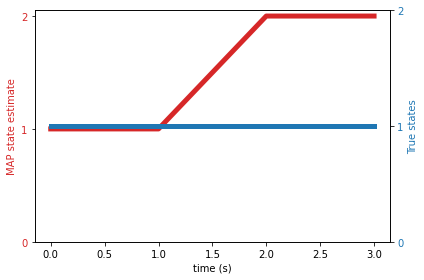

In [42]:
fig, ax1 = plt.subplots()

trajectory_index = 0

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MAP state estimate', color=color)
ax1.plot(t, np.argmax(state_inference[trajectory_index], axis=1), color=color, linewidth=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0, 1, 2])

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('True states', color=color)  
ax2.step(t, true_states[trajectory_index], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

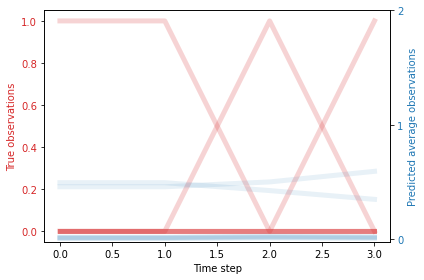

In [43]:
fig, ax1 = plt.subplots()

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('True observations', color=color)
ax1.plot(t, X_observations[trajectory_index], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Predicted average observations', color=color)  
ax2.plot(t, expected_observations[trajectory_index], color=color, linewidth=5, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

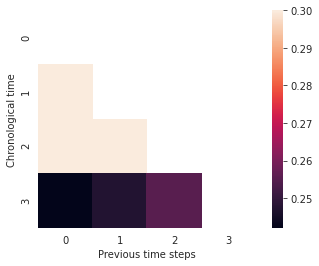

In [44]:
# Visualize the attention weights over time
import seaborn as sns

Attention_weights = []

for w in range(len(attention[0])):
    
    Attention_weights.append(np.vstack((attention[0][w], np.zeros((len(attention[0][-1]) - len(attention[0][w]),1)))))


Attention_weights = np.array(Attention_weights).reshape((len(attention[0][-1]), len(attention[0][-1])))[:state_inference[0].shape[0], :state_inference[0].shape[0]]

mask = np.zeros_like(Attention_weights)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(Attention_weights, mask=mask, vmax=.3, square=True)
    ax.set_ylabel('Chronological time')
    ax.set_xlabel('Previous time steps')